In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.linalg import solve
from numpy.random import default_rng

rng = default_rng()

# -- Parameters
theta_min, theta_max, N_theta = -10, 10, 200
theta_grid = np.linspace(theta_min, theta_max, N_theta)
delta_theta = theta_grid[1] - theta_grid[0]

# Fermi occupation function (example)
def epsilon(theta): return theta**2 / 2.0  # Free fermions
def n_fermi(theta): return 1.0 / (1.0 + np.exp(epsilon(theta)))
n_theta = n_fermi(theta_grid)

# 1. Monte Carlo sampling of Bethe roots
def monte_carlo_sampling(n_theta, theta_grid, num_samples=1000):
    samples = []
    for _ in range(num_samples):
        occupancy = rng.random(len(n_theta)) < n_theta
        hist, _ = np.histogram(theta_grid[occupancy], bins=theta_grid)
        samples.append(hist)
    samples = np.array(samples)
    mean_rho = np.mean(samples, axis=0)
    var_rho = np.var(samples, axis=0)
    return mean_rho, var_rho

# 2. Langevin GHD (simplified diffusive model)
def ghd_stochastic(theta_grid, n_theta, timesteps=100, dt=0.1):
    rho = n_theta.copy()
    D_theta = rho * (1 - n_theta) * (theta_grid**2)  # Toy diffusion term
    history = [rho.copy()]
    for _ in range(timesteps):
        noise = rng.normal(0, 1, size=rho.shape) * np.sqrt(D_theta * dt / delta_theta)
        rho += np.gradient(D_theta * np.gradient(rho, delta_theta), delta_theta) * dt + noise
        history.append(rho.copy())
    return np.array(history)

# 3. Thermodynamic fluctuation matrix
def dressed_function(f, n_theta, kernel):
    A = np.eye(N_theta) - delta_theta * kernel * n_theta[None, :]
    return solve(A, f)

def compute_variance(f, n_theta, kernel):
    f_dr = dressed_function(f, n_theta, kernel)
    integrand = n_theta * (1 - n_theta) * f_dr**2
    return simps(integrand, theta_grid)

# Kernel (free fermions: zero kernel; interacting case can be added)
kernel = np.zeros((N_theta, N_theta))  # For free fermions: φ = 0

# Run all three methods
mean_rho_mc, var_rho_mc = monte_carlo_sampling(n_theta, theta_grid)
rho_stoch_history = ghd_stochastic(theta_grid, n_theta)
f = theta_grid  # Linear function
var_thermo = compute_variance(f, n_theta, kernel)

# Output for plotting
mean_rho_mc[:5], var_rho_mc[:5], rho_stoch_history[-1][:5], var_thermo


/var/folders/sc/1jlhfymx3sg5vz8q1fx87pvr0000gn/T/ipykernel_97427/839513856.py:50: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return simps(integrand, theta_grid)


(array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([ 2.31246660e-09, -1.35751369e-09, -1.68142960e-09,  1.52424894e-10,
        -8.62624515e-09]),
 1.516256042886594)

In [3]:
# Re-importing necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# Paramètres
theta = np.linspace(-5, 5, 200)
n_theta = 1 / (1 + np.exp(theta**2))  # fonction d'occupation de Fermi (exemple)

# 1. Monte Carlo : approximation de rho par histogrammes
samples = 500
rho_mc = np.zeros_like(theta)
rho_mc_samples = []

for _ in range(samples):
    mask = np.random.rand(len(theta)) < n_theta
    rho_sample = mask.astype(float)
    rho_mc += rho_sample
    rho_mc_samples.append(rho_sample)

rho_mc_mean = rho_mc / samples
rho_mc_var = np.var(rho_mc_samples, axis=0)

# 2. Langevin : ajout de bruit stochastique à la densité
D_theta = n_theta * (1 - n_theta) * theta**2
noise = np.random.normal(0, np.sqrt(D_theta), size=theta.shape)
rho_langevin = n_theta + noise

# 3. Thermodynamique : variance théorique (ici f(theta) = theta)
f_theta = theta
f_dr = f_theta  # sans interaction, dressing trivial
var_thermo = n_theta * (1 - n_theta) * f_dr**2

# Affichage
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(theta, rho_mc_mean, label="Monte Carlo (moyenne)", color='blue')
plt.plot(theta, rho_langevin, label="Langevin", color='red', alpha=0.7)
plt.plot(theta, n_theta, label="Occupation moyenne $n(\\theta)$", color='black', linestyle='--')
plt.title("Estimations de $\rho(\\theta)$")
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\rho(\theta)$')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(theta, rho_mc_var, label="Variance Monte Carlo", color='blue')
plt.plot(theta, D_theta, label="Variance Langevin ($D(\\theta)$)", color='red', linestyle='--')
plt.plot(theta, var_thermo, label="Variance Thermodynamique", color='green')
plt.title("Comparaison des fluctuations")
plt.xlabel(r'$\theta$')
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()


ValueError: 
Estimations de $ho(\theta)$
               ^
ParseException: Expected end of text, found '$'  (at char 15), (line:1, col:16)

Error in callback <function _draw_all_if_interactive at 0x10782c180> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
Estimations de $ho(\theta)$
               ^
ParseException: Expected end of text, found '$'  (at char 15), (line:1, col:16)

ValueError: 
Estimations de $ho(\theta)$
               ^
ParseException: Expected end of text, found '$'  (at char 15), (line:1, col:16)

<Figure size 1400x600 with 2 Axes>

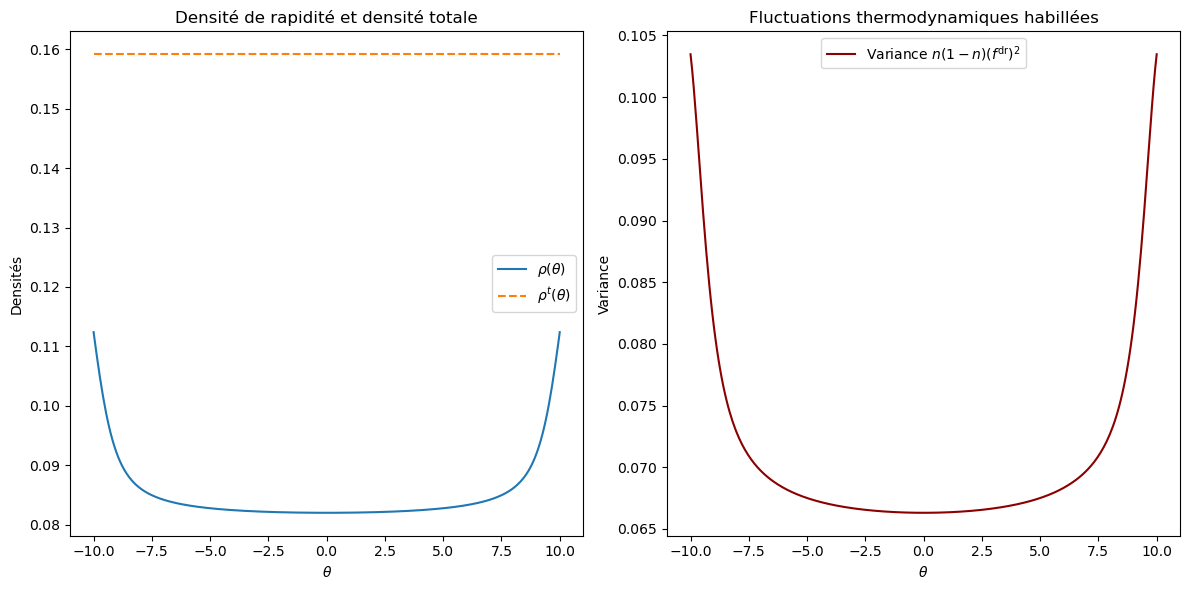

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve
from scipy.interpolate import interp1d

# Parameters
c = 1.0  # interaction strength
theta_min, theta_max = -10, 10
N_theta = 300
theta_grid = np.linspace(theta_min, theta_max, N_theta)
dtheta = theta_grid[1] - theta_grid[0]

# Kernel for Lieb-Liniger model
def K(theta_diff, c):
    return 2 * c / (theta_diff**2 + c**2)

# Bare energy and density of states
def epsilon(theta):
    return theta**2

# Source term: thermal equilibrium distribution at temperature T and chemical potential mu
T = 1.0
mu = 0.0
def n_0(theta):
    return 1.0 / (1.0 + np.exp((epsilon(theta) - mu) / T))

# Discretized Kernel matrix
K_matrix = np.zeros((N_theta, N_theta))
for i in range(N_theta):
    for j in range(N_theta):
        K_matrix[i, j] = K(theta_grid[i] - theta_grid[j], c) * dtheta / (2 * np.pi)

# Total density of states: rho^t = 1/(2pi) + K * rho
Id = np.eye(N_theta)
rho_total = np.ones(N_theta) / (2 * np.pi)  # source term

# Solve (Id + K) * rho = rho_total => rho = inv(Id + K) * rho_total
rho = solve(Id + K_matrix, rho_total)

# Compute filling function n = rho / rho^t
rho_t = rho + K_matrix @ rho
n_filling = rho / rho_t

# Compute dressed charge f^dr = (Id + K)^{-1} * f for f = 1
f = np.ones(N_theta)
f_dr = solve(Id + K_matrix, f)

# Compute thermodynamic variance: n(1 - n)(f^dr)^2
variance = n_filling * (1 - n_filling) * f_dr**2

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(theta_grid, rho, label=r'$\rho(\theta)$')
plt.plot(theta_grid, rho_t, label=r'$\rho^t(\theta)$', linestyle='--')
plt.title('Densité de rapidité et densité totale')
plt.xlabel(r'$\theta$')
plt.ylabel(r'Densités')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(theta_grid, variance, label=r'Variance $n(1-n)(f^{\mathrm{dr}})^2$', color='darkred')
plt.title('Fluctuations thermodynamiques habillées')
plt.xlabel(r'$\theta$')
plt.ylabel('Variance')
plt.legend()

plt.tight_layout()
plt.show()
